In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder, FunctionTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
from tqdm.notebook import tqdm

**Main function**

Pipeline Progress:   0%|          | 0/9 [00:00<?, ?step/s]


Initial Check
Dropping columns with high missing data:  ['Cabin']
No duplicate columns found.
The target variable 'Survived' is present in the DataFrame.

-----------------------------Initial check done-----------------------------------------------


Imputation
Total Null value counts before imputation: 
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64

Total Null value counts: 
 PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

-----------------------------Imputation Done-----------------------------------------------


Handling Imbalanced Data

-----------------------------Balanced the data-----------------------------------------------


Removing Outliers

Origi

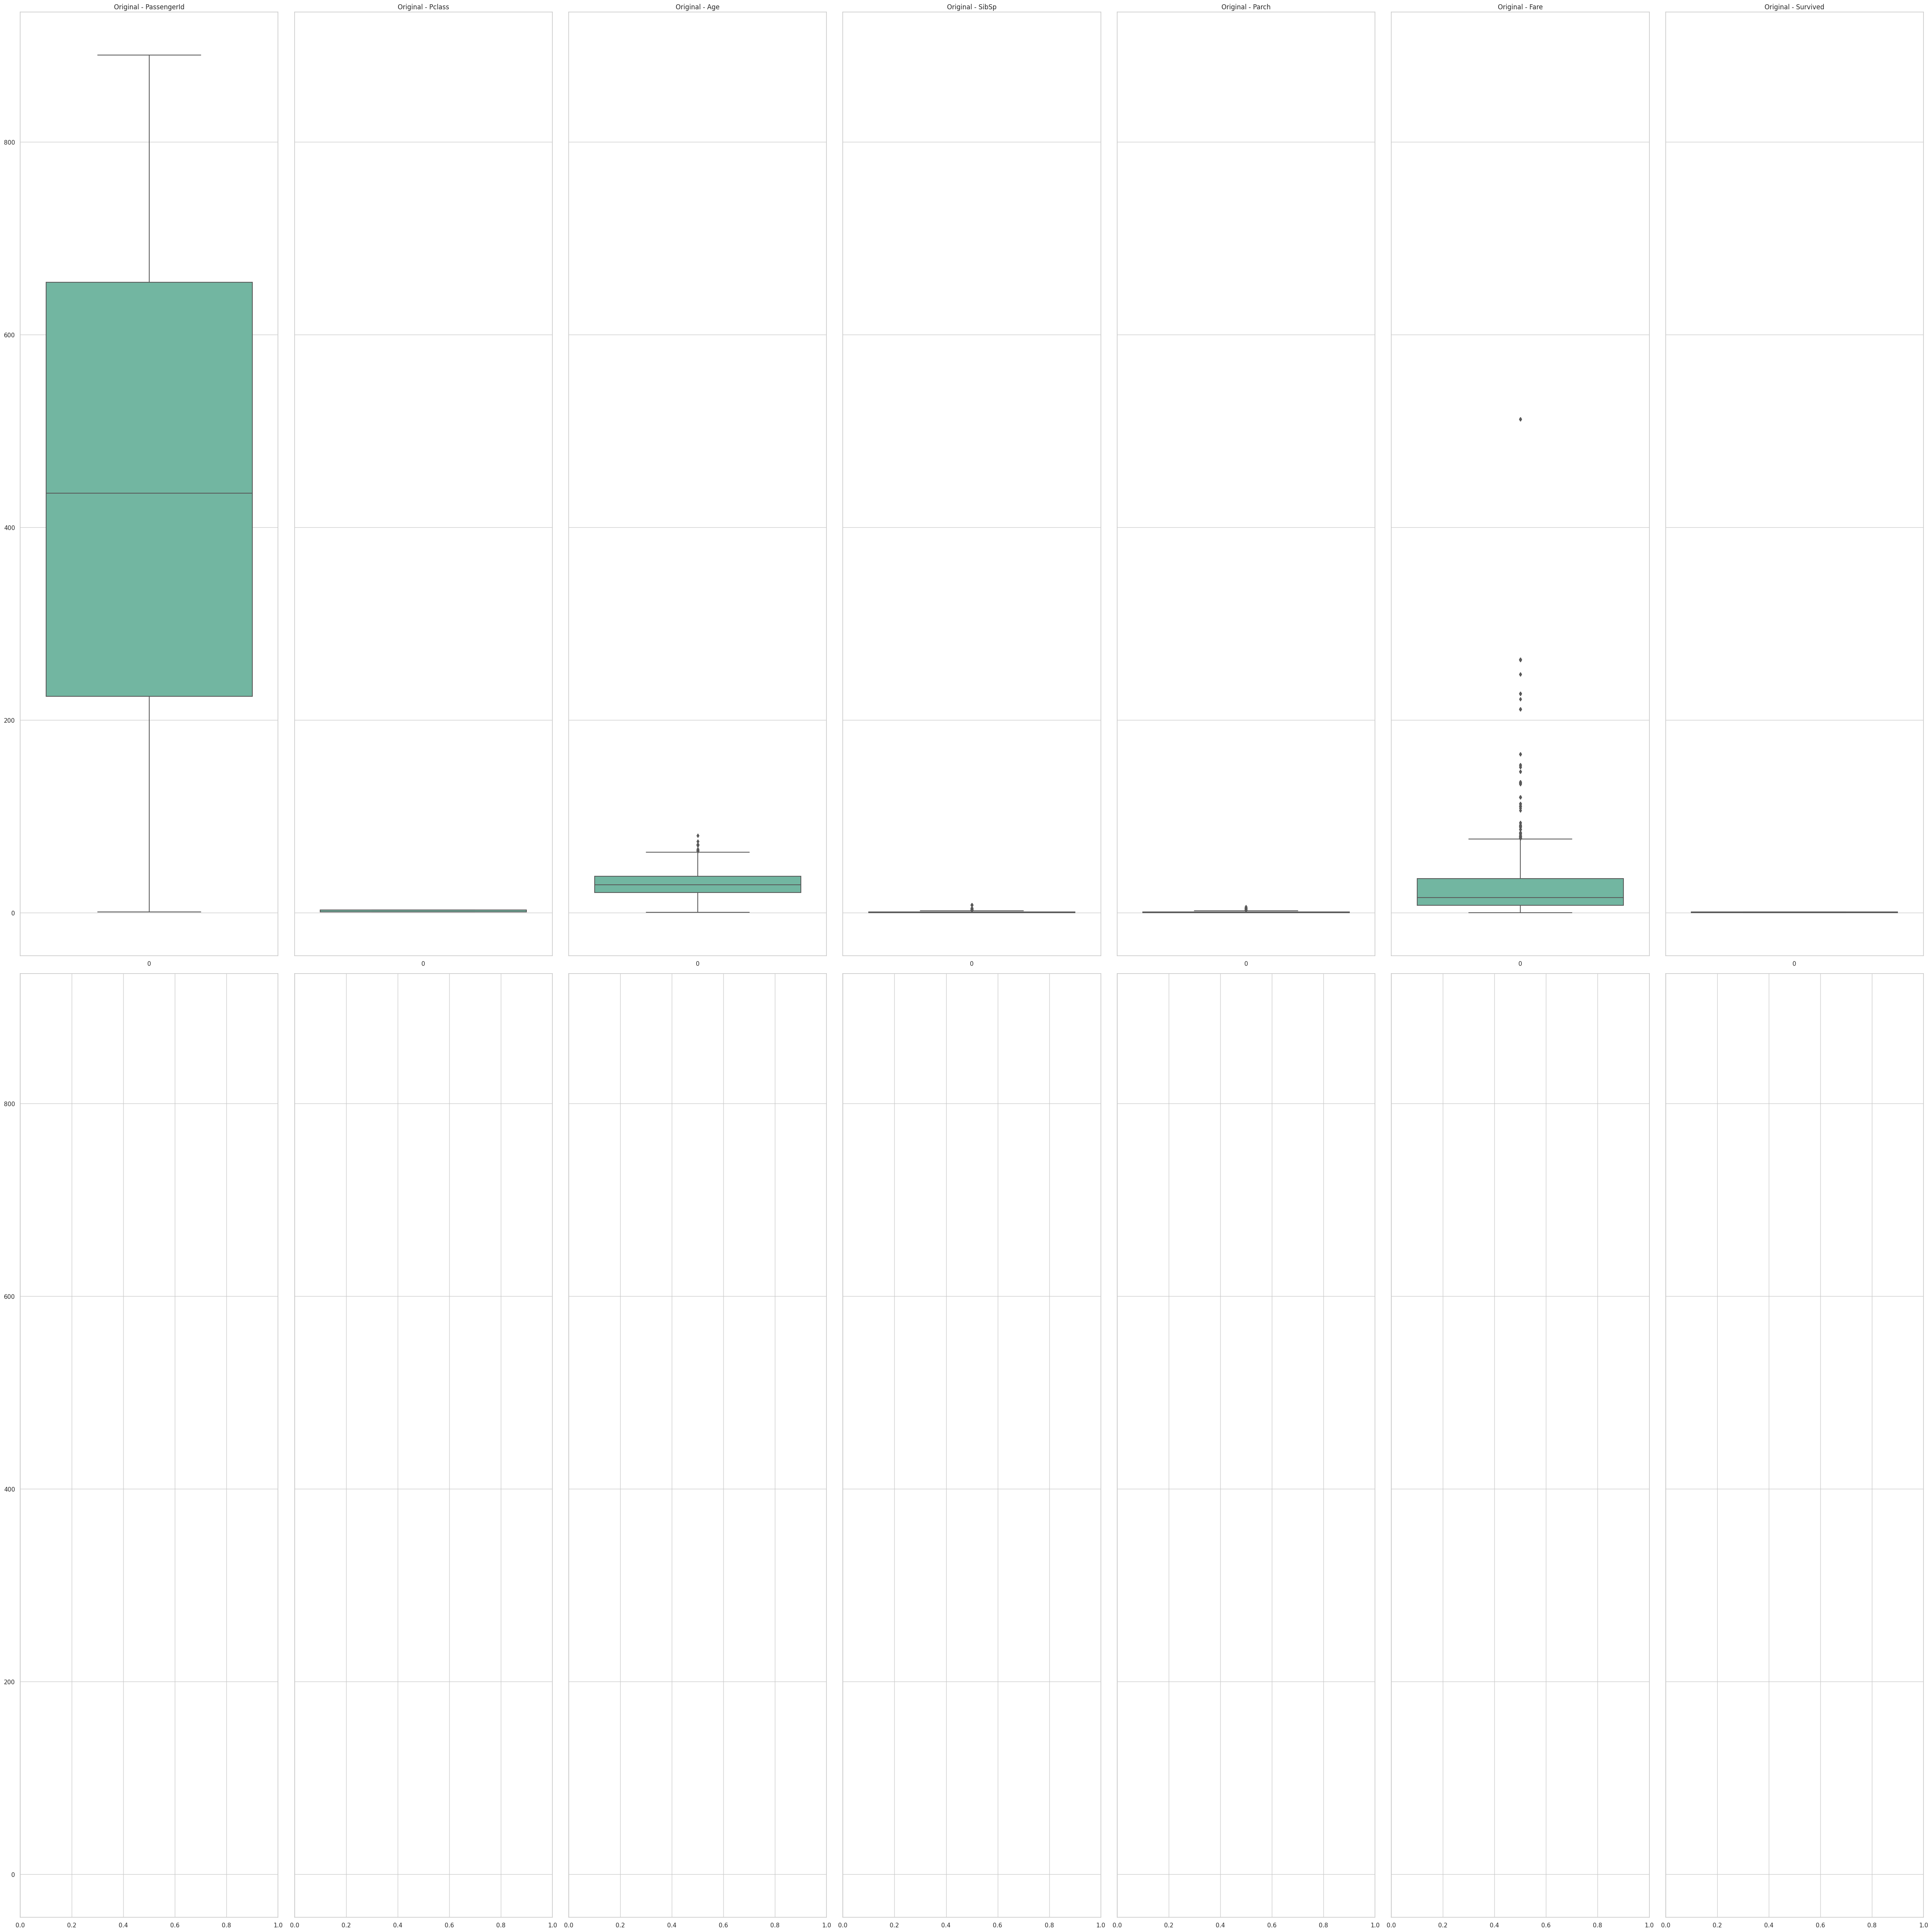


-----------------------------Removed Outliers-----------------------------------------------


Separating Input and Output

-----------------------------Separated the input and output-----------------------------------------------


Finding Correlations
Before:  (684, 6)
Initial VIF values: 
       Feature       VIF
1       Pclass  4.384522
2          Age  4.061142
0  PassengerId  3.482706
5         Fare  1.731251
4        Parch  1.542372
3        SibSp  1.509981
After:  (684, 6)


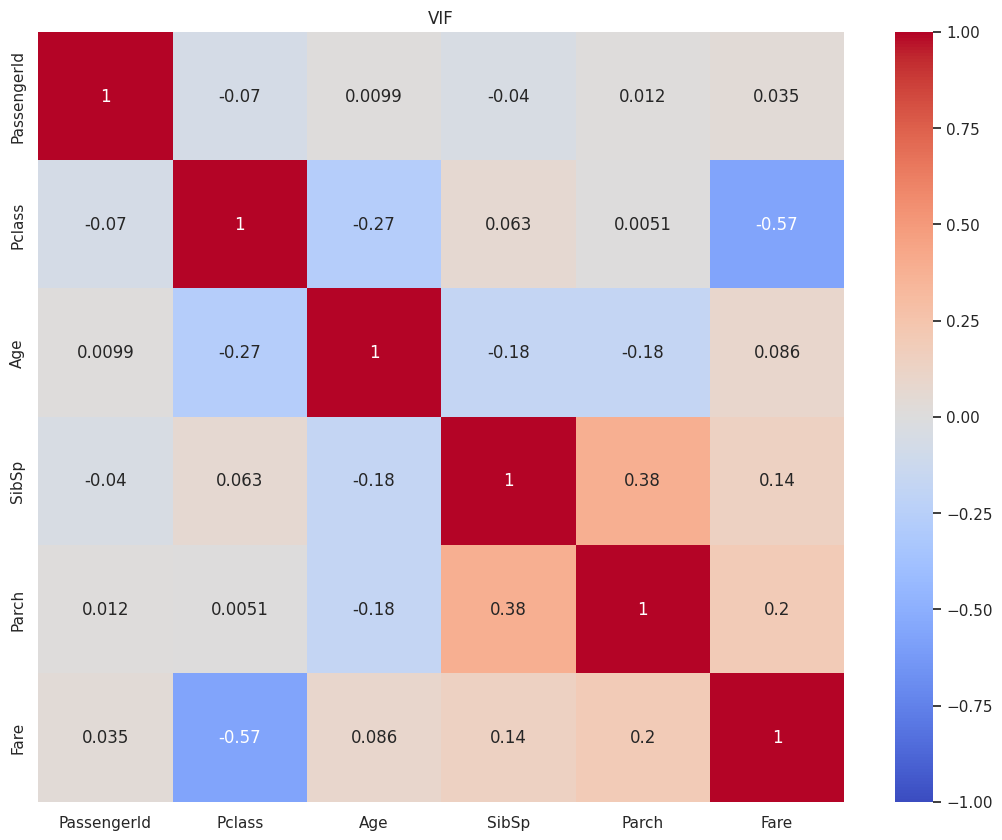


-----------------------------Found the correlations-----------------------------------------------


Encoding Data

-----------------------------Encoded the data-----------------------------------------------


Feature Scaling
Algorithms: 

KNN
SVM
KMeans
Gradient Descent
Linear Regression
Logistic Regression
Lasso and Ridge Regression
Neural Networks



If you utilize any of these algorithms you can scale your data by giving 'Y' or else 'N' :  Y



Minmax scaled columns: 
 ['Age', 'SibSp', 'Parch', 'Fare', 'Name', 'Ticket']

Standardized columns: 
 ['Pclass', 'Sex_male', 'Embarked_Q', 'Embarked_S']

Scaled data


-----------------------------Feature Scaling Done-----------------------------------------------


Displaying the results

Original Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 


In [10]:
def intial_check(file_path, target_variable):
    if file_path.lower().endswith('.csv'):
        try:
            df = pd.read_csv(file_path)
        except pd.errors.ParserError:
            print("File cannot be parsed as a CSV.")
            return None
        except Exception as e:
            print(f"An error occurred: {e}")
            return None
        
        id_list = ['ID', 'Id', 'id', 'index', 'Index']
        id_drop = [col for col in df.columns if col in id_list]
        if id_drop:
            df = df.drop(columns=id_drop)
            print(f"Dropped columns: {', '.join(id_drop)}")
            
        drop_columns = []
        for col in df.columns:
            missing_count = df[col].isnull().sum()
            total_values = len(df[col])
            missing_percentage = (missing_count / total_values) * 100

            if missing_percentage > 40:
                drop_columns.append(col)
        print("Dropping columns with high missing data: ", list(drop_columns))
        df = df.drop(columns=drop_columns)
        
        df_columns = df.columns.tolist() 
        seen = {}
        duplicates = set()
        keep_indices = []

        for index, col in enumerate(df.columns):
            if col in seen:
                duplicates.add(col)
            else:
                seen[col] = index
                keep_indices.append(index)
    
        if duplicates:
            print("Duplicate columns:", list(duplicates))
        else:
            print("No duplicate columns found.")

        df = df.iloc[:, keep_indices]
        
        if target_variable in df_columns:
            print(f"The target variable '{target_variable}' is present in the DataFrame.")
        else:
            print(f"The target variable '{target_variable}' is missing in the DataFrame.")
            
        return df
    else:
        print("Oops :( The file is not a CSV file!")
        return None

def imputing(type_impute: int, df1: pd.DataFrame) -> pd.DataFrame:
    df = df1.copy()  # Create a copy to avoid modifying the original DataFrame
    
    print("Total Null value counts before imputation: \n",df.isnull().sum())
    
    if type_impute == 0:
        for column in df.columns:
            if pd.api.types.is_numeric_dtype(df[column]):
                df[column] = df[column].fillna(df[column].mean())
            else:
                df[column] = df[column].fillna(df[column].mode()[0])
    elif type_impute == 1:
        for column in df.columns:
            if pd.api.types.is_numeric_dtype(df[column]):
                df[column] = df[column].interpolate(method='linear')
            else:
                df[column] = df[column].fillna(df[column].mode()[0])
    else:
        raise ValueError("Invalid type. Expected 0, 1, or 2.")
        
    print("\nTotal Null value counts: \n",df.isnull().sum())
    return df


def handle_imbalanced_data(df,target,strategy='undersampling', k_neighbors=2):

    if strategy == 'oversampling':
        sampler = RandomOverSampler()
    elif strategy == 'undersampling':
        sampler = RandomUnderSampler()
    elif strategy == 'smote':
        sampler = SMOTE(k_neighbors=k_neighbors)
    else:
        raise ValueError("Invalid strategy. Choose from 'oversampling', 'undersampling', or 'smote'.")
        
    X_res, y_res=separate_target_column(df,target)
    X_res, y_res = sampler.fit_resample(X_res, y_res)
    df_balanced = pd.concat([X_res, y_res], axis=1)
    
    return df_balanced

def remove_outliers(raw_df):
    numerical_features = raw_df.select_dtypes(include=['float64', 'int64']).columns
    df_original = raw_df.copy()

    outlier_counts = pd.Series(0, index=df_original.index)
    threshold = 3
    col_count = len(numerical_features)

    for col in numerical_features:
        z_scores = np.abs(stats.zscore(df_original[col]))
        outliers = z_scores > threshold
        outlier_counts += outliers
        col_count += 1

    # Remove rows with a significant number of outliers, here 3 or more columns
    df_pre_processed = df_original[outlier_counts < 3]

    print(f"\nOriginal data count: {len(df_original)}")
    print(f"After outlier removal data count: {len(df_pre_processed)}")

    sns.set(style="whitegrid")

    # Get numerical columns
    numerical_cols = df_original.select_dtypes(include=['int64', 'float64']).columns

    # Define the figure and axes for the subplots
    fig, axes = plt.subplots(nrows=2, ncols=len(numerical_cols), figsize=(50, 50), sharey=True)
    
    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Plot box-plots for original and pre-processed dataframe
    for i, column in enumerate(numerical_cols):
        if i < len(axes) // 2:
            sns.boxplot(data=df_original[column], ax=axes[i], palette="Set2")
            axes[i].set_title(f'Original - {column}')
        else:
            sns.boxplot(data=df_pre_processed[column], ax=axes[i], palette="Set2")
            axes[i].set_title(f'Pre-Processed - {column}')

        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

    # Adjust layout
    plt.tight_layout()
    plt.show()

    return df_pre_processed


def separate_target_column(df, target_column):
    target = df[target_column]
    remaining_df = df.drop(columns=[target_column])
    return remaining_df, target



def plot_filtered_correlation_matrix(df):
    numerical_columns = df.select_dtypes(include=['float64', 'int64'])
    non_numerical_columns = df.select_dtypes(exclude=['float64', 'int64']).columns
    print("Before: ", numerical_columns.shape)
    
    vif = pd.DataFrame()
    vif['Feature'] = numerical_columns.columns
    vif["VIF"] = [variance_inflation_factor(numerical_columns.values, i) for i in range(numerical_columns.shape[1])]
    
    print("Initial VIF values: ")
    print(vif.sort_values(by="VIF", ascending=False))
    
    infinite_vif_features = vif[vif["VIF"] == np.inf]["Feature"].tolist()
    if infinite_vif_features:
        print(f"\nDropping columns with infinite VIF values: {infinite_vif_features}\n")
        numerical_columns = numerical_columns.drop(columns=infinite_vif_features)
        
    max_vif = 10
    remove_flag = True
    
    while remove_flag:
        vif = pd.DataFrame()
        vif['Feature'] = numerical_columns.columns
        vif["VIF"] = [variance_inflation_factor(numerical_columns.values, i) for i in range(numerical_columns.shape[1])]
        
        max_vif_feature = vif.loc[vif['VIF'].idxmax()]
        
        if max_vif_feature['VIF'] > max_vif:
            numerical_columns = numerical_columns.drop(max_vif_feature['Feature'], axis=1)
            print(f"Removed variable with high VIF {max_vif_feature['Feature']} (VIF={max_vif_feature['VIF']})")
        else:
            remove_flag = False
            
    df_correlated = pd.concat([numerical_columns, df[non_numerical_columns]], axis=1)
    
    print("After: ", numerical_columns.shape)
    
    plt.figure(figsize=(13,10))
    plt.title("VIF")
    sns.heatmap(numerical_columns.corr(),annot=True,fmt='0.2g',cmap='coolwarm',vmin=-1,vmax=1)
    plt.show()
    
    return df_correlated

def encoding(features: pd.DataFrame) -> pd.DataFrame:
    for column in features.columns:
        if features[column].dtype == "object":
            if features[column].nunique() > 3:
                encoder = LabelEncoder()
                features[column] = encoder.fit_transform(features[column])
            else:
                encoder = OneHotEncoder(sparse_output=False, drop='first')
                encoded = encoder.fit_transform(features[[column]])
                encoded_features = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([column]), index=features.index)
                features.drop(columns=[column], inplace=True)
                features[encoded_features.columns] = encoded_features

    return features

def feature_scaling(df,target,unscale_column):
    
    
    algorithms = ['KNN', 'SVM', 'KMeans', 'Gradient Descent', 'Linear Regression', 'Logistic Regression', 'Lasso and Ridge Regression', 'Neural Networks']
    
    print("Algorithms: \n")
    for algo in algorithms:
        print(algo)
        
    answer = input("\nIf you utilize any of these algorithms you can scale your data by giving 'Y' or else 'N' : ")
    
    if answer.upper() == 'Y':
        
        numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
        non_numerical_columns = df.select_dtypes(exclude=['float64', 'int64']).columns
        
        if unscale_column in numerical_columns:
            unscaled_data = df[[unscale_column]]
            numerical_columns = numerical_columns.drop(unscale_column)
        
        Minmaxscaler_algorithms = []
        Standardscaler_algorithms = []
        
        for col in numerical_columns:
            unique_count = df[col].nunique()
            
            if unique_count > 3:
                scaler = MinMaxScaler()
                Minmaxscaler_algorithms.append(col)
            else:
                scaler = StandardScaler()
                Standardscaler_algorithms.append(col)
            
            df[col] = scaler.fit_transform(df[[col]])
            
        print("\nMinmax scaled columns: \n", Minmaxscaler_algorithms)
        print("\nStandardized columns: \n", Standardscaler_algorithms)
        
        df_scaled = pd.concat([df[numerical_columns], df[non_numerical_columns]], axis=1)
        df_scaled[target.name] = target.values
        
        if not unscaled_data.empty:
            df_scaled = pd.concat([unscaled_data, df_scaled], axis=1)
            
        df_scaled = df_scaled.reset_index(drop=True)
                
        print("\nScaled data\n")

        return df_scaled
    else:
        df[target.name] = target.values
        return df
    
def display(file_path,df):
    original_data=pd.read_csv(file_path)
    processed_data=df
    print("\nOriginal Data\n")
    original_data.info()
    print("\nProcessed Data\n")
    processed_data.info()

def preprocess_pipeline(file_path, target_column):
    total_steps = 9  # Total number of steps in the pipeline
    progress_bar = tqdm(total=total_steps, desc="Pipeline Progress", unit="step")
    
    print("\nInitial Check")
    df = intial_check(file_path, target_column)
    progress_bar.update(1)
    print("\n-----------------------------Initial check done-----------------------------------------------\n")
    
    print("\nImputation")
    df = imputing(1, df)
    progress_bar.update(1)
    print("\n-----------------------------Imputation Done-----------------------------------------------\n")
    
    print("\nHandling Imbalanced Data")
    df = handle_imbalanced_data(df, target_column)
    progress_bar.update(1)
    print("\n-----------------------------Balanced the data-----------------------------------------------\n")
    
    print("\nRemoving Outliers")
    df = remove_outliers(df)
    progress_bar.update(1)
    print("\n-----------------------------Removed Outliers-----------------------------------------------\n")
    
    print("\nSeparating Input and Output")
    remaining_df, target = separate_target_column(df, target_column)
    progress_bar.update(1)
    print("\n-----------------------------Separated the input and output-----------------------------------------------\n")
    
    print("\nFinding Correlations")
    remaining_df = plot_filtered_correlation_matrix(remaining_df)
    progress_bar.update(1)
    print("\n-----------------------------Found the correlations-----------------------------------------------\n")
    
    print("\nEncoding Data")
    remaining_df = encoding(remaining_df)
    progress_bar.update(1)
    print("\n-----------------------------Encoded the data-----------------------------------------------\n")
    
    print("\nFeature Scaling")
    preprocessed_df = feature_scaling(remaining_df, target,unscale_column)
    progress_bar.update(1)
    print("\n-----------------------------Feature Scaling Done-----------------------------------------------\n")
    
    print("\nDisplaying the results")
    display(file_path,preprocessed_df)
    progress_bar.update(1)
    print("\n-----------------------------Displayed the final results-----------------------------------------------\n")
    
    progress_bar.close()
    return preprocessed_df

file_path = '/kaggle/input/titanic/train.csv'
target_column ='Survived'
unscale_column='PassengerId'

processed_data = preprocess_pipeline(file_path, target_column)
data=pd.read_csv(file_path)


In [4]:
processed_data.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Name,Ticket,Sex_male,Embarked_Q,Embarked_S,Survived
0,404,0.883851,0.346569,0.125,0.0,0.030937,0.363104,0.979127,0.855363,-0.301511,0.633750,0
1,426,0.883851,0.283740,0.000,0.0,0.014151,0.976574,0.764706,0.855363,-0.301511,0.633750,0
2,630,0.883851,0.660719,0.000,0.0,0.015094,0.699854,0.432638,0.855363,3.316625,-1.577909,0
3,155,0.883851,0.569615,0.000,0.0,0.014273,0.710102,0.838710,0.855363,-0.301511,0.633750,0
4,479,0.883851,0.271174,0.000,0.0,0.014680,0.487555,0.607211,0.855363,-0.301511,0.633750,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  684 non-null    int64  
 1   Pclass       684 non-null    float64
 2   Age          684 non-null    float64
 3   SibSp        684 non-null    float64
 4   Parch        684 non-null    float64
 5   Fare         684 non-null    float64
 6   Name         684 non-null    float64
 7   Ticket       684 non-null    float64
 8   Sex_male     684 non-null    float64
 9   Embarked_Q   684 non-null    float64
 10  Embarked_S   684 non-null    float64
 11  Survived     684 non-null    int64  
dtypes: float64(10), int64(2)
memory usage: 64.2 KB
